# Inventory Optimization

This was an assignment from my Operations Analytics course. The use case here is to apply both basic and contextual newsvendor models to a Nurses Staffing problem.

In [1]:
from gurobipy import *
import numpy as np
import pandas as pd

In [2]:
nurse_df = pd.read_csv("nurse.csv")
nurse_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Day             300 non-null    int64  
 1   DailyED         300 non-null    int64  
 2   IsWeekend       300 non-null    int64  
 3   IsHoliday       300 non-null    int64  
 4   DailyEDLag1     300 non-null    int64  
 5   DailyEDLag2     300 non-null    int64  
 6   PriorSurgeries  300 non-null    float64
dtypes: float64(1), int64(6)
memory usage: 16.5 KB


In [3]:
# Split train and test

nurse_train = nurse_df.iloc[:200]
nurse_test = nurse_df.iloc[200:]

### Part 1: Formulating a basic newsvendor model

**(a)** Suppose that on a given day, there are 12 ED cases, and we have staffed 18 regular nurses. The staffing cost incurred by the hospital would be **\\$38,880** = (18 * \\$2,160 ). The hospital could pay $12,960 *less* if not for being over-staffed.

**(b)** Suppose that there are 8 ED cases, and we have staffed 5 regular nurses. The staffing cost incurred by the hospital would be **\\$27,000** = (5 * \\$2,160 + 3 * \\$5,400). The hospital would pay $9,720 *less* if not for being under-staffed.

**(c)** Formulate the problem as to minimize daily expected cost:

Suppose $Q$ is the number of regular nurses hired each day and $D$ is the number of ED cases each day.

- $c_o$, overage cost, occurs when $Q$ > $D$ so it is \\$2,160 per regular nurse whom I didn't have to pay if I get my staffing level just right

- $c_u$, underage cost, occurs when $D$ > $Q$ so it is \\$3,240 (= 5,400 - 2,160) in addition to the regular nurse wage that I have to pay if I get my staffing level just right

Then, the formulation of this cost-based problem is

$$ \min_Q \mathbb{E}[ 3240 * \max\{D - Q, 0\} + 2160 * \max\{Q - D, 0\} + 2160 * D] $$

In other words, the optimal order quantity is the $c_u/(c_u + c_o) = 3240 / 5400 $ quantile of the demand distribution. 

**(d)** The "un-avoidable” cost component is the cost of hiring regular nurses in addition to the "avoidable" costs in the overage and underage scenarios.

$$ 2160 * D $$

In [4]:
print(18*2160)

print(18*2160 - 12*2160)

print(5*2160 + 3*5400)

print(3*5400 - 3*2160)

38880
12960
27000
9720


### Part 2: Solving the basic newsvendor model

**(a)** Based on the overage and underage costs from Part 1, the optimal staffing level corresponds to the following quantile of the empirical distribution of `DailyED` is

$$ c_u/(c_u + c_o) = 3240 / (3240 + 2160) = 0.6 $$

**(b)** Based on the empirical distribution of `DailyED` in the training set, the optimal staff level is **16**.

**(c)** The average cost over the 200 days in the training set that this staffing level would incur is **$41,256**.

**(d)** The average cost over the 100 days in the test set that this staffing level would incur is **$39,528**.

In [5]:
c_u = 5400 - 2160
c_o = 2160
baseline_nv_quantile = c_u / (c_u + c_o)
print( baseline_nv_quantile )

0.6


In [6]:
dailyED = nurse_df['DailyED']
baseline_optimal = dailyED.quantile(baseline_nv_quantile)
print( baseline_optimal )

16.0


In [7]:
Q = baseline_optimal

def calculate_daily_cost(D):
    return c_u * max(D - Q, 0) + c_o * max(Q - D, 0) + c_o * D

In [8]:
daily_cost = np.array( list(map( calculate_daily_cost, nurse_train['DailyED'])) )
expected_cost = daily_cost.mean()
print( expected_cost )

41256.0


In [9]:
daily_cost = np.array( list(map( calculate_daily_cost, nurse_test['DailyED'])) )
expected_cost = daily_cost.mean()
print( expected_cost )

39528.0


### Part 3: Solving the contextual newsvendor model

**(a)** The regression tree first split at whether `PriorSurgeries` is less than or equal to 21.571 or not. If it is true, it continues to use `PriorSurgeries` as the feature to split; the tree predicts the average number of regular nurses to staff is approximately 12 if `PriorSurgeries` is less than or equal to 16.429, or approximately 14 otherwise. 

If the `PriorSurgeries` is more than 21.571 at the root node, the tree uses `DailyEDLag2` as the feature to split at this node. The tree predicts the average number of regular nurses to staff is approximately 18 if `DailyEDLag2` is less than or equal to 10.5, or approximately 16 otherwise.

**(b)** For each leaf of the tree, the optimal staffing level (rounded to the nearest integer) for the corresponding conditional distribution of `DailyED` given the training set is:

- **Leaf 2: 13**
- **Leaf 3: 15**
- **Leaf 5: 18**
- **Leaf 6: 17**

**(c)** Under the contextualized model, the average cost over the 200 days in the training set would be **$40,554**.

**(d)** Under the contextualized model, the average cost over the 100 days in the test set would be **$38,772**.

In [10]:
nurse_columns = nurse_df.columns[2:]
print(nurse_columns)

X_train = nurse_train[ nurse_columns ]
X_train = np.asarray(X_train)

y_train = nurse_train[ 'DailyED' ]
y_train = np.asarray(y_train)

Index(['IsWeekend', 'IsHoliday', 'DailyEDLag1', 'DailyEDLag2',
       'PriorSurgeries'],
      dtype='object')


In [11]:
# Load the tree module
import sklearn.tree as tree

# Estimate the regression tree model
nurse_tree = tree.DecisionTreeRegressor(max_depth = 2)
nurse_tree = nurse_tree.fit(X_train,y_train)

# Inspect the nurse_tree object
nurse_tree

DecisionTreeRegressor(max_depth=2)

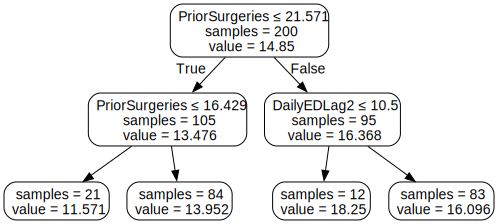

In [12]:
# Use the graphviz library to plot the tree
import graphviz 
dot_data = tree.export_graphviz(nurse_tree, out_file=None,
                                feature_names=nurse_columns, impurity=False, 
                                rounded=True,  
                                special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("nurse") 
graph

In [13]:
# Get the predicted leaves
leaf_mapping = nurse_tree.apply(X_train)
# print(len(leaf_mapping))
# print(leaf_mapping)
# print([ leaf_mapping[i] for i in range(len(leaf_mapping)) ])

In [14]:
leaves = [i for i in range(nurse_tree.tree_.node_count) if nurse_tree.tree_.children_left[i] == -1 ]
print(leaves)

leaf_to_quantile = np.zeros( nurse_tree.tree_.node_count )

print(baseline_nv_quantile)

for ell in leaves:
    ind = leaf_mapping == ell  # for every training obs check if it is in that leaf
    y_ell = y_train[ind]
    leaf_to_quantile[ell] = round(np.quantile(y_ell, baseline_nv_quantile))
    
leaf_to_quantile

[2, 3, 5, 6]
0.6


array([ 0.,  0., 13., 15.,  0., 18., 17.])

In [15]:
train_set_decisions = leaf_to_quantile[leaf_mapping]
# print(train_set_decisions)

train_set_cost = c_u * np.maximum(y_train - train_set_decisions, 0) + c_o * np.maximum(train_set_decisions - y_train, 0) + c_o * y_train
avg_train_set_cost = train_set_cost.mean(axis = 0)
print("Average in-sample cost (contextual newvendor):", avg_train_set_cost)

Average in-sample cost (contextual newvendor): 40554.0


In [16]:
X_test = nurse_test[ nurse_columns ]
X_test = np.asarray(X_test)

y_test = nurse_test[ 'DailyED' ]
y_test = np.asarray(y_test)

In [17]:
test_set_leaves = nurse_tree.apply(X_test)
# print(test_set_leaves)

test_set_decisions = leaf_to_quantile[test_set_leaves]
# print(test_set_decisions)

test_set_cost = c_u * np.maximum(y_test - test_set_decisions, 0) + c_o * np.maximum(test_set_decisions - y_test, 0) + c_o * y_test
avg_test_set_cost = test_set_cost.mean(axis = 0)
print("Average out-of-sample cost (contextual newvendor):", avg_test_set_cost)

Average out-of-sample cost (contextual newvendor): 38772.0
